In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
from arch import arch_model
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima_process import ArmaProcess
from scipy.stats import norm

# Simulación

In [2]:
mu =0
omega = 0.1
alpha = 0.4
beta = 0.3
sim_mod = arch_model(None, p=1, o=0, q=1,dist="normal")
params = {"mu":mu,"omega": omega,"alpha[1]":alpha,"beta[1]":beta}
param = pd.Series(params)

n=100


In [3]:
np.random.seed(69)
datos_simulados = []
for i in range(n):
    sim_data = sim_mod.simulate(param, 1000000)
    datos_simulados.append(sim_data["data"])


In [ ]:
sim_data

In [ ]:
plt.plot(datos_simulados[20])

In [ ]:
plt.hist(datos_simulados[10],bins=32,density=True)
f_normal = lambda x : np.exp(-x**2/2)/np.sqrt(2*np.pi)
x = np.linspace(-14, 14, 1000)
plt.plot(x,f_normal(x));


# EXTRACTO PENSADO PARA SERIES, NO MIRAR SI QUIERE CODIGO PARA SIMULACIÓN

In [ ]:
plot_acf(datos_simulados[1]);

In [ ]:
plot_pacf(datos_simulados[3]);

In [ ]:
plot_acf(datos_simulados[1]**2);

In [ ]:
plot_pacf(datos_simulados[3]**2);

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Parámetros del modelo ARMA(1,1)
phi_1 = 0.7
theta_1 = 0.4

# Coeficientes del ARMA(1,1)
ar_params = np.array([1,-phi_1])
ma_params = np.array([1,-theta_1])

# Número de rezagos a considerar
lag = 10

# Crear un modelo ARMA(1,1)
arma_model = sm.tsa.ArmaProcess(ar_params, ma_params)

# Calcular la autocorrelación teórica
acf_values = arma_model.acf(lag)
x = np.arange(10)
acf_values

In [ ]:
pru =  [1]+acf_mean[1:10].tolist()
plt.scatter(x,acf_values);
plt.scatter(x,pru,color="red");

# FIN DEL EXTRACTO PENSADO PARA SERIES

# PACF y ACF

## ACF

ACF toerica del $\epsilon^{2}$ para un garch(1,1), extraida del libro GARCH Forecasting Model pág 50 del libro a


In [4]:
def acf_garch(a,b,h):
    # h>=1
    p_1 = a*(1-b*(a+b))/(1-(a+b)**2+a**2) 
    p_h = p_1 *(a+b)**(h-1)
    return p_h
    

In [5]:
acf_teory = []
for i in range(1,20):
    acf_teory.append(acf_garch(alpha,beta,i))
    
x = np.arange(1,20)



In [6]:
acf_teory

[0.47164179104477616,
 0.3301492537313433,
 0.23110447761194028,
 0.1617731343283582,
 0.11324119402985074,
 0.0792688358208955,
 0.055488185074626856,
 0.038841729552238795,
 0.027189210686567152,
 0.019032447480597008,
 0.013322713236417903,
 0.009325899265492533,
 0.006528129485844772,
 0.00456969064009134,
 0.0031987834480639377,
 0.0022391484136447563,
 0.0015674038895513293,
 0.0010971827226859303,
 0.0007680279058801512]

In [7]:
acfs = []
for i in range(n):
    acfs.append(acf(np.square(datos_simulados[i]),nlags = 20))

In [8]:

df = pd.DataFrame(acfs, columns=np.arange(0, 21))
acf_mean = df.mean()
acf_mean[1:20]

1     0.457673
2     0.314428
3     0.217060
4     0.151036
5     0.103889
6     0.071453
7     0.050017
8     0.035014
9     0.023921
10    0.016586
11    0.011295
12    0.007868
13    0.005212
14    0.003609
15    0.002490
16    0.001678
17    0.001175
18    0.000714
19    0.000782
dtype: float64

Comparación de lo teorico con el promedio de la afc de las $n$ trayectorias

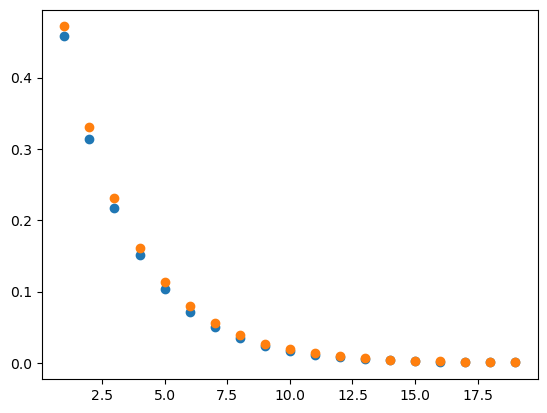

In [9]:
plt.scatter(x,acf_mean[1:20])
plt.scatter(x,acf_teory);

## PACF

In [ ]:
def pacf_garch(corr,h):
    a = [1]
    for i in range(19):
        for j in range(19):
            print("nose")
            
    
    

# Ajuste
Ajuste de las n trayectorias a traves del estimador maximo verosimil 
Se ocupa el resultado Trabajo de Grado sobre Modelos ARCH y GARCH en la pagina 30 del lector de pdf(28 en la hoja) sobre normalidad asintotica

In [ ]:
columns = ["mu","omega","alpha1","beta1"]
parametros = pd.DataFrame(columns=columns)
parametros
for i in range(n):
    modelo = arch_model(datos_simulados[i], p=1, o=0, q=1)
    res = modelo.fit(disp="off")
    new_row = pd.DataFrame([res.params.values], columns=columns)
    parametros = pd.concat([parametros,new_row], axis=0)
    
    

In [ ]:
parametros.head()

In [ ]:
parametros.hist(figsize=(10, 8), grid = False,bins=32);

In [ ]:
plt.hist(parametros["alpha1"],bins=32,density=True);
f_normal = lambda x : np.exp(-(x-alpha)**2/(2*np.var(parametros["alpha1"],)))/np.sqrt(2*np.pi*np.var(parametros["alpha1"]))
x = np.linspace(0, 1, 1000)
plt.plot(x,f_normal(x));

In [ ]:
parametros.mean()

In [ ]:
parametros.var()

# Teorema 5.1
Teorema 5.1 del libro GARCH Forecasting Model pág 94

In [ ]:
acfs51 = []
for i in range(n):
    acfs51.append(acf(datos_simulados[i],nlags = 10))

In [ ]:
p1 = []
for i in range(len(acfs51)):
    p1.append(np.sqrt(len(datos_simulados[1]))*acfs51[i][2])

In [ ]:
plt.hist(p1,bins=32,density=True);
f_normal = lambda x : np.exp(-x**2/(2*np.var(p1)))/np.sqrt(2*np.pi*np.var(p1))
f_normal2 = lambda x : np.exp(-x**2/(2*final))/np.sqrt(2*np.pi*final)
x = np.linspace(-14, 14, 1000)
plt.plot(x,f_normal(x));
plt.plot(x,f_normal2(x));

In [ ]:
np.array(p1).var()

In [ ]:
def varianza(omega,a,b,h):
    t1 = ((1+a+b)*(a+b)**h) / ((1-(a+b)**2-2*a**2)*(1-a-b))
    t2 = (1-(a+b)**h)/(1+a+b)**2
    return omega**2*(t1+t2)

In [ ]:
v = varianza(omega,alpha,beta,2)
sigma = omega/(1-alpha-beta)
final = v/sigma**2

In [ ]:
final

In [ ]:
def cov(datos):
    suma =0
    n = len(datos)
    for i in range(n):
        suma = suma+ datos[i]**2
    return suma/n

In [ ]:
suma =0
for i in range(len(datos_simulados)):
    suma = suma + cov(datos_simulados[1])*acfs51[i][1]
suma = suma/len(datos_simulados)
suma/sigma